In [1]:
import xarray as xr
import cftime 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import logging
import cartopy.crs as ccrs
import metpy  # accessor needed to parse crs
import calendar
import argparse

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("scenario", help = '')
parser.add_argument("model", help = '')
parser.add_argument("cvar", help = '')
args = parser.parse_args()

usage: ipykernel_launcher.py [-h] future historical cvar
ipykernel_launcher.py: error: the following arguments are required: historical, cvar


SystemExit: 2

/home/smmrrr/miniconda3/envs/condaforge/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [59]:

##create a lookup table that matches TEM var names to CMIP
##this is only for variables without any var transformation

TEM2CMIP_varnames = np.array([['tair', 'prec'],
['tas' ,'pr']])



'ttpr'

In [38]:
tt

array([['tair', 'prec'],
       ['tas', 'pr']], dtype='<U4')

In [65]:
scenario = 'rcp45'
model = 'GFDL-CM3'
cvar = 'tair'

In [115]:
# import sys
# ###use sysparse instead
# ##fstrings can let you put variables in a string
# print('Number of arguments:', len(sys.argv), 'arguments.')
# print('Argument List:', str(sys.argv))

In [68]:
folder1 = 'TEM_Climate_Data/'

# else:
cvar_lookup = np.where(TEM2CMIP_varnames == cvar)[1] ##look up location of tem var 
cvar_match = TEM2CMIP_varnames[1, cvar_lookup] ##get cmip var
cmip_var = re.sub('[\[\]\']', '', np.array_str(cvar_match)) #clean format of cmip var

ds_historical = xr.open_dataset('~/'+folder1+cmip_var+'_'+scenario+'/'+model+'_concat.nc')
ds_future = xr.open_dataset('~/'+folder1+cmip_var+'_historical/'+model+'_concat.nc')
ds = ds_historical.combine_first(ds_future)

ds['var_of_interest'] = ds[cmip_var]
ds = ds.drop_vars([cmip_var])

# ds = ds.drop_vars(['vas', 'uas'])    




In [73]:
ds.var_of_interest

print(ds.var_of_interest.max())
print(ds.var_of_interest.min())


# ds_max

<xarray.DataArray 'var_of_interest' ()>
array(320.5155, dtype=float32)
Coordinates:
    height   float64 2.0
<xarray.DataArray 'var_of_interest' ()>
array(193.04016, dtype=float32)
Coordinates:
    height   float64 2.0


<xarray.Dataset>
Dimensions:          (time: 3012, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * time             (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lat              (lat) float64 -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
  * lon              (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
    height           float64 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds        (time, bnds) object 1850-01-01 00:00:00 ... 2101-01-01 0...
    lat_bnds         (lat, bnds) float64 -87.86 -86.48 -86.48 ... 86.48 87.86
    lon_bnds         (lon, bnds) float64 -1.406 1.406 1.406 ... 355.8 358.6
    var_of_interest  (time, lat, lon) float32 1.615 1.62 1.633 ... 2.928 2.906
Attributes: (12/28)
    institution:               FIO(The First Institution of Oceanography,SOA,...
    institute_id:              FIO
    experiment_id:             rcp45
    source:                    FIO-ESM
    model_id:                  FIO-ESM
    forcing:                   Nat,Ant
    ...                        ...
    parent_experiment:         historical
    modeling_realm:            atmos
    realization:               1
    cmor_version:              2.8.0
    NCO:                       4.7.2
    nco_openmp_thread_number:  1

In [74]:
folder1 = 'TEM_Climate_Data/'
# folder2 = 'TEM__preprocess_examples'

if (cvar == 'trange'):

    ds_historical_max = xr.open_dataset('~/'+folder1+'tasmax_'+scenario+'/'+model+'_concat.nc')
    ds_future_max = xr.open_dataset('~/'+folder1+'tasmax_historical/'+model+'_concat.nc')
    ds_historical_min = xr.open_dataset('~/'+folder1+'tasmin_'+scenario+'/'+model+'_concat.nc')
    ds_future_min = xr.open_dataset('~/'+folder1+'tasmin_historical/'+model+'_concat.nc')

    ds_max = ds_historical_max.combine_first(ds_future_max)
    ds_min = ds_historical_min.combine_first(ds_future_min)

    ds = xr.merge([ds_max
                   , ds_min])

    ds['var_of_interest'] = ds['tasmax'] -  ds['tasmin']
    ds = ds.drop_vars(['tasmin', 'tasmax'])    

elif (cvar == 'wind'):
    
    ds_historical_uas = xr.open_dataset('~/'+folder1+'uas_'+scenario+'/'+model+'_concat.nc')
    ds_future_uas = xr.open_dataset('~/'+folder1+'uas_historical/'+model+'_concat.nc')
    ds_historical_vas = xr.open_dataset('~/'+folder1+'vas_'+scenario+'/'+model+'_concat.nc')
    ds_future_vas = xr.open_dataset('~/'+folder1+'vas_historical/'+model+'_concat.nc')

    ds_uas = ds_historical_uas.combine_first(ds_future_uas)
    ds_vas = ds_historical_vas.combine_first(ds_future_vas)

    ds = xr.merge([ds_uas
                   , ds_vas])

    ds['var_of_interest'] = np.sqrt(ds['uas']**2 +  ds['vas']**2)
    

else:
    cvar_lookup = np.where(TEM2CMIP_varnames == cvar)[1] ##look up location of tem var 
    cvar_match = TEM2CMIP_varnames[1, cvar_lookup] ##get cmip var
    cmip_var = re.sub('[\[\]\']', '', np.array_str(cvar_match)) #clean format of cmip var

    ds_historical = xr.open_dataset('~/'+folder1+cmip_var+'_'+scenario+'/'+model+'_concat.nc')
    ds_future = xr.open_dataset('~/'+folder1+cmip_var+'_historical/'+model+'_concat.nc')
    ds = ds_historical.combine_first(ds_future)

    ds['var_of_interest'] = ds[cmip_var]
    ds = ds.drop_vars([cmip_var])

    
### read in files

# ds_historical = xr.open_dataset('~/'+folder2+'/'+'tas_Amon_ACCESS1-0_historical_r1i1p1_185001-200512.nc')
# ds_future = xr.open_dataset('~/'+folder2+'/'+'tas_Amon_ACCESS1-0_rcp85_r1i1p1_200601-210012.nc')
# ds = ds_historical.combine_first(ds_future)

# ds_historical = xr.open_dataset(args.historical)
# ds_future = xr.open_dataset(args.future)

TEM = pd.read_csv('~/TEM__preprocess_examples/igsmtbaselv0.5x0.5degree.glb'
                 ,names = [ 'lon', 'lat', 'Variable', 'Area', 'Elev','Area_Name'])

# TEM['lat'] = TEM['lat'] + 90 + 0.25  #check this is correct
# TEM['lon'] = TEM['lon'] + 180 + 0.25 #check this is correct


In [87]:
# ds_historical

In [88]:
# TEM
# TEM.describe()


In [5]:
# ds

## get coordinates 
systime = time.ctime(time.time())
print(f"\nStart time: {systime}")


Start time: Wed Jul 27 12:17:11 2022


In [6]:
# ds = xr.concat([ds_historical, ds_future], dim = 'y')


#### SWITCH COORDS ON CLIMATE DATA
#Convert longitude coordinates from 0-359 to -180-179
ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
# move lat / lon up .25 degrees to account for center vs. corner of grid cell


ds = ds.sortby('lon')

ds = ds.drop_dims('bnds')

ds = ds.drop_vars('height')
ds

<xarray.Dataset>
Dimensions:  (time: 3012, lat: 145, lon: 192)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 -180.0 -178.1 -176.2 -174.4 ... 174.4 176.2 178.1
Data variables:
    tas      (time, lat, lon) float32 252.7 252.7 252.7 ... 270.1 270.1 270.1
Attributes: (12/28)
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institute_id:           CSIRO-BOM
    experiment_id:          historical
    source:                 ACCESS1-0 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    model_id:               ACCESS1-0
    forcing:                GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4...
    ...                     ...
    table_id:               Table Amon (27 April 2011) 9c851218e3842df9a62ef3...
    title:                  ACCESS1-0 model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.8.0

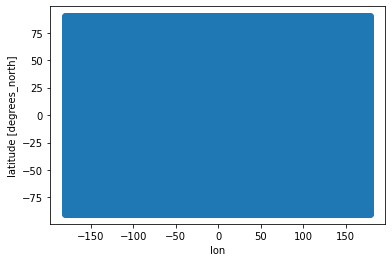

In [7]:
ds.plot.scatter(x = 'lon', y = 'lat') #, hue = 'Area_Name')

<AxesSubplot:xlabel='lon', ylabel='lat'>

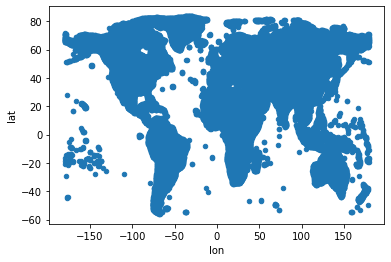

In [8]:
TEM.plot.scatter(x = 'lon', y = 'lat') #, hue = 'Area_Name')

In [9]:
tas_mean = ds.groupby(ds.time.dt.year).mean()
tas_min = ds.groupby(ds.time.dt.year).min()
tas_max = ds.groupby(ds.time.dt.year).max()
tas_sum = ds.groupby(ds.time.dt.year).sum()


In [10]:
tas_stats = xr.merge([tas_sum.rename({'tas':'sum'}), 
                      tas_max.rename({'tas':'max'}),
                    tas_mean.rename({'tas':'average'}),
                      tas_min.rename({'tas':'min'})
                     ])
tas_stats

<xarray.Dataset>
Dimensions:  (year: 251, lat: 145, lon: 192)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 -180.0 -178.1 -176.2 -174.4 ... 174.4 176.2 178.1
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Data variables:
    sum      (year, lat, lon) float32 2.709e+03 2.709e+03 ... 3.248e+03
    max      (year, lat, lon) float32 254.3 254.3 254.3 ... 281.9 281.9 281.9
    average  (year, lat, lon) float32 225.8 225.8 225.8 ... 270.7 270.7 270.7
    min      (year, lat, lon) float32 205.8 205.8 205.8 ... 254.8 254.8 254.8

In [11]:
monthly = xr.merge([ds.isel(time=(ds.time.dt.month == n)).rename(
            {'tas': calendar.month_abbr[n] }) for n in range(1, 13)])

monthly = monthly.groupby(ds.time.dt.year).min()

# tt.groupby(ds.time.dt.year).max() ##check they are the same



In [12]:
final = xr.merge([tas_stats, 
                      monthly
         ])
final

<xarray.Dataset>
Dimensions:  (year: 251, lat: 145, lon: 192)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 -180.0 -178.1 -176.2 -174.4 ... 174.4 176.2 178.1
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Data variables: (12/16)
    sum      (year, lat, lon) float32 2.709e+03 2.709e+03 ... 3.248e+03
    max      (year, lat, lon) float32 254.3 254.3 254.3 ... 281.9 281.9 281.9
    average  (year, lat, lon) float32 225.8 225.8 225.8 ... 270.7 270.7 270.7
    min      (year, lat, lon) float32 205.8 205.8 205.8 ... 254.8 254.8 254.8
    Jan      (year, lat, lon) float32 252.7 252.7 252.7 ... 266.2 266.2 266.2
    Feb      (year, lat, lon) float32 238.7 238.7 238.7 ... 259.1 259.1 259.1
    ...       ...
    Jul      (year, lat, lon) float32 208.4 208.4 208.4 ... 279.6 279.6 279.6
    Aug      (year, lat, lon) float32 205.8 205.8 205.8 ... 281.9 281.9 281.9
    Sep      (year, lat, lon) float32 213.5 213.5 213.5 ... 279.8 279.8 279.8
    Oct      (year, lat, lon) float32 221.1 221.1 221.1 ... 275.4 275.4 275.4
    Nov      (year, lat, lon) float32 245.2 245.2 245.2 ... 272.4 272.4 272.4
    Dec      (year, lat, lon) float32 254.3 254.3 254.3 ... 270.1 270.1 270.1

In [13]:
#### DO THE NEAREST LON/LAT 

##old method
# TEM = TEM.set_index(['lon', 'lat'])
# TEM_xr = TEM.to_xarray()

#new method 
# TEM = TEM.reset_index()
TEM_xr = TEM.set_index(['lon', 'lat'])
TEM_xr = TEM_xr[['Area', 'Area_Name']].to_xarray()

TEM_xr = TEM_xr.assign_coords(lon=(TEM_xr.lon + 0.25))
TEM_xr = TEM_xr.assign_coords(lat=(TEM_xr.lat + 0.25))


ds_TEM = final.reindex_like(TEM_xr, method = 'nearest')
ds_TEM

<xarray.Dataset>
Dimensions:  (lon: 720, lat: 280, year: 251)
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 -55.75 -55.25 -54.75 -54.25 ... 82.75 83.25 83.75
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Data variables: (12/16)
    sum      (year, lat, lon) float32 3.333e+03 3.333e+03 ... 3.247e+03
    max      (year, lat, lon) float32 282.3 282.3 282.4 ... 279.1 279.1 279.1
    average  (year, lat, lon) float32 277.8 277.8 277.7 ... 270.6 270.6 270.6
    min      (year, lat, lon) float32 274.6 274.6 274.6 ... 256.1 256.1 256.1
    Jan      (year, lat, lon) float32 281.4 281.4 281.3 ... 268.2 268.2 268.2
    Feb      (year, lat, lon) float32 282.3 282.3 282.4 ... 260.4 260.4 260.4
    ...       ...
    Jul      (year, lat, lon) float32 275.5 275.5 275.4 ... 276.0 276.0 276.0
    Aug      (year, lat, lon) float32 274.9 274.9 274.9 ... 279.1 279.1 279.1
    Sep      (year, lat, lon) float32 276.0 276.0 275.8 ... 278.2 278.2 278.2
    Oct      (year, lat, lon) float32 277.1 277.1 277.0 ... 275.4 275.4 275.4
    Nov      (year, lat, lon) float32 277.6 277.6 277.4 ... 273.3 273.3 273.3
    Dec      (year, lat, lon) float32 278.7 278.7 278.6 ... 271.6 271.6 271.6

In [89]:
# TEM_xr.sel(lon = -180, lat = -16.5)
# ds_TEM.sel(lon = -180, year = 1960)

In [90]:
#verify that the nearest lon/lat is working 
# final.sel(lat = -55.25, lon = -180.25, year = 1960).to_pandas()
# ds_TEM.sel(lat = -55.5, lon = -180, year = 1960).to_pandas()



In [14]:
##take a look at bounds of lat/lon in final vs ds_TEM
print(final['lon'])
# print(ds_TEM['lon'])

print(final['lat'])
# print(ds_TEM['lat']) ## !!!is the -0.25 right on the edge cases of -90 and 90?!!!

<xarray.DataArray 'lon' (lon: 192)>
array([-180.   , -178.125, -176.25 , -174.375, -172.5  , -170.625, -168.75 ,
       -166.875, -165.   , -163.125, -161.25 , -159.375, -157.5  , -155.625,
       -153.75 , -151.875, -150.   , -148.125, -146.25 , -144.375, -142.5  ,
       -140.625, -138.75 , -136.875, -135.   , -133.125, -131.25 , -129.375,
       -127.5  , -125.625, -123.75 , -121.875, -120.   , -118.125, -116.25 ,
       -114.375, -112.5  , -110.625, -108.75 , -106.875, -105.   , -103.125,
       -101.25 ,  -99.375,  -97.5  ,  -95.625,  -93.75 ,  -91.875,  -90.   ,
        -88.125,  -86.25 ,  -84.375,  -82.5  ,  -80.625,  -78.75 ,  -76.875,
        -75.   ,  -73.125,  -71.25 ,  -69.375,  -67.5  ,  -65.625,  -63.75 ,
        -61.875,  -60.   ,  -58.125,  -56.25 ,  -54.375,  -52.5  ,  -50.625,
        -48.75 ,  -46.875,  -45.   ,  -43.125,  -41.25 ,  -39.375,  -37.5  ,
        -35.625,  -33.75 ,  -31.875,  -30.   ,  -28.125,  -26.25 ,  -24.375,
        -22.5  ,  -20.625,  -18.75 ,  -1

In [16]:
## TEM is higher resolution than the climate data
# 3012*720*280 #months x lon x lat 
# 3012*192*145 #months x lon x lat 
#83854080 #number of rows in climate dataset
#607219200 #number of rows in matched dataset 
print(ds_TEM.Jan.count())
print(final.Jan.count())


<xarray.DataArray 'Jan' ()>
array(50601600)
<xarray.DataArray 'Jan' ()>
array(6987840)


In [ ]:
#### FORMAT USING OLD SCRIPT 

#get list of variable names
#do the correct transformation by variable name 

In [290]:
# list(range(10, 310, 10))


In [17]:

for i in range(10, 310, 10):

    rep_decade = ds_TEM.sel(year = slice(1850, 1859))
    rep_decade['year'] = rep_decade.year - i

    if i == 10:
        rep_past = rep_decade
    else:
        rep_past = rep_past.combine_first(rep_decade)

    print(i)
    
    
rep_past

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300


<xarray.Dataset>
Dimensions:  (year: 300, lat: 280, lon: 720)
Coordinates:
  * year     (year) int64 1550 1551 1552 1553 1554 ... 1845 1846 1847 1848 1849
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 -55.75 -55.25 -54.75 -54.25 ... 82.75 83.25 83.75
Data variables: (12/16)
    sum      (year, lat, lon) float32 3.333e+03 3.333e+03 ... 3.046e+03
    max      (year, lat, lon) float32 282.3 282.3 282.4 ... 272.9 272.9 272.9
    average  (year, lat, lon) float32 277.8 277.8 277.7 ... 253.8 253.8 253.8
    min      (year, lat, lon) float32 274.6 274.6 274.6 ... 236.7 236.7 236.7
    Jan      (year, lat, lon) float32 281.4 281.4 281.3 ... 239.1 239.1 239.1
    Feb      (year, lat, lon) float32 282.3 282.3 282.4 ... 236.7 236.7 236.7
    ...       ...
    Jul      (year, lat, lon) float32 275.5 275.5 275.4 ... 272.7 272.7 272.7
    Aug      (year, lat, lon) float32 274.9 274.9 274.9 ... 271.1 271.1 271.1
    Sep      (year, lat, lon) float32 276.0 276.0 275.8 ... 261.8 261.8 261.8
    Oct      (year, lat, lon) float32 277.1 277.1 277.0 ... 253.6 253.6 253.6
    Nov      (year, lat, lon) float32 277.6 277.6 277.4 ... 248.3 248.3 248.3
    Dec      (year, lat, lon) float32 278.7 278.7 278.6 ... 241.7 241.7 241.7

In [18]:
ds_TEM = ds_TEM.combine_first(rep_past)

print(ds_TEM.year.min())
print(ds_TEM.year.max())


<xarray.DataArray 'year' ()>
array(1550)
<xarray.DataArray 'year' ()>
array(2100)


In [19]:
ds_TEM = xr.merge([ds_TEM, TEM_xr])

In [20]:
ds_TEM2 = ds_TEM.to_dataframe()

In [21]:
ds_TEM2 = ds_TEM2.dropna()

In [22]:
ds_TEM2 = ds_TEM2.reset_index()

In [23]:
print(ds_TEM2['lat'].nunique())
print(ds_TEM2['lon'].nunique())
print(ds_TEM2['year'].nunique())

280
720
551


In [24]:
# 280*720*551
cvar = 'temp'

In [25]:
ds_TEM2['var'] = ' ' + cvar + ' '


ds_TEM2 = ds_TEM2[["lon", 'lat','var' ,'Area', 'year', 'sum', 'max', 'average'
         , 'min', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'
         , 'Nov', 'Dec', 'Area_Name']]



In [ ]:

ds_TEM2.to_csv('~/TEM_Monthly/cleaned_climate_input/'+'.csv',index = False)

In [26]:
# ds

## get coordinates 
systime = time.ctime(time.time())
print(f"\nStart time: {systime}")


Start time: Wed Jul 27 12:23:19 2022


In [ ]:
###### old program that is too slow replicated from R program TEM_historical_kelley_chu.R


# i = 1
# year = 1888


# lon = round(TEM.loc[i, 'lon'], 4)
# lat = round(TEM.loc[i, 'lat'], 4)
    
# if (lat < 0 or lon < 0):  ##is this what we want?? lat is 
#                     #always negative so this isnt doing anything
#     lat = lat + 90
#     lon = lon + 180
            
# lat = lat + 0.25
# lon = lon + 0.25
        
# if year < 1861:
#     year_l = str(year)
#     year_l = year_l[-1]
#     year_l = 1860 + int(year_l)
# else: 
#     year_l = year
    
# t_index = np.min(np.where(ds['time'].dt.year == year_l))
# t_index = t_index +  [i for i in range(12)]
# lon_index = np.argmin(np.array(np.abs(ds['lon'] - lon)))
# lat_index = np.argmin(np.array(np.abs(ds['lat'] - lat)))
# ds_subset = ds.isel(time=t_index, lat = [lat_index], lon = [lon_index])
# ds_subset = ds_subset.to_dataframe()
# ds_subset = ds_subset.reset_index()
# ds_subset['sum_val'] = ds_subset['tas'].sum()
# ds_subset['min_val'] = ds_subset['tas'].min()
# ds_subset['max_val'] = ds_subset['tas'].max()
# ds_subset['avg_val'] = ds_subset['tas'].mean()
# ds_subset['var'] = TEM.loc[i, 'Variable']
# ds_subset['area'] = TEM.loc[i, 'Area']
# ds_subset['year'] = year
# ds_subset['lat_TEM'] = lat
# ds_subset['lon_TEM'] = lon
